# Water Tank Depletion Prediction using Machine Learning

This notebook implements machine learning models to predict the next water tank level based on current features including input/output flow rates and tank levels.

## Overview
- **Data Source**: Tank_Data.csv containing water flow and tank level measurements
- **Target**: Predict next tank level based on current features
- **Models**: Linear Regression, Random Forest, and XGBoost
- **Features**: Input flow, output flow, flow difference, current tank level, and time features

## 1. Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# For XGBoost
try:
    import xgboost as xgb
    print(f"Using XGBoost version: {xgb.__version__}")
except ImportError:
    print("XGBoost not available. Please install with: pip install xgboost")
    raise

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Using XGBoost version: 3.0.4
All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## 2. Load and Explore Data

In [2]:
# Load the data
try:
    df = pd.read_csv('Tank_Data.csv')
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: Tank_Data.csv file not found in current directory")
    print("Please ensure the file is in the same directory as this notebook")
    raise

print("\nFirst few rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

print("\nColumn names:")
print(df.columns.tolist())

print("\nMissing values:")
print(df.isnull().sum())

Dataset loaded successfully!
Dataset shape: (3000, 9)

First few rows:


,Input_Flow_Date,Input_Flow_Value,Input_Flow_Unit,Tank_Date,Tank_Level,Tank_Unit,Out_Flow_Date,Out_Flow_Value,Out_Flow_Unit
0,01/07/2025 00:00,39.153,m3/h,01/07/2025 00:01,6.864,m3,01/07/2025 00:02,-0.7344,m3/h
1,01/07/2025 00:10,113.360,m3/h,01/07/2025 00:11,6.625,m3,01/07/2025 00:12,0.0000,m3/h
2,01/07/2025 00:20,113.470,m3/h,01/07/2025 00:21,6.628,m3,01/07/2025 00:22,-1.7064,m3/h
3,01/07/2025 00:30,0.000,m3/h,01/07/2025 00:31,7.034,m3,01/07/2025 00:32,0.0000,m3/h
4,01/07/2025 00:40,112.010,m3/h,01/07/2025 00:41,6.925,m3,01/07/2025 00:42,-1.7316,m3/h



Data types:
Input_Flow_Date      object
Input_Flow_Value    float64
Input_Flow_Unit      object
Tank_Date            object
Tank_Level          float64
Tank_Unit            object
Out_Flow_Date        object
Out_Flow_Value      float64
Out_Flow_Unit        object
dtype: object

Column names:
['Input_Flow_Date', 'Input_Flow_Value', 'Input_Flow_Unit', 'Tank_Date', 'Tank_Level', 'Tank_Unit', 'Out_Flow_Date', 'Out_Flow_Value', 'Out_Flow_Unit']

Missing values:
Input_Flow_Date       0
Input_Flow_Value      0
Input_Flow_Unit       0
Tank_Date             0
Tank_Level          190
Tank_Unit             0
Out_Flow_Date         0
Out_Flow_Value        0
Out_Flow_Unit         0
dtype: int64


## 3. Data Cleaning and Preprocessing

In [3]:
# Strip leading/trailing spaces from column names
df.columns = df.columns.str.strip()
print(f"Column names after stripping: {df.columns.tolist()}")

# Convert date columns to datetime
date_columns = ['Input_Flow_Date', 'Tank_Date', 'Out_Flow_Date']
for col in date_columns:
    try:
        df[col] = pd.to_datetime(df[col], format='%d/%m/%Y %H:%M', errors='coerce')
        print(f"Converted {col} to datetime")
    except Exception as e:
        print(f"Error converting {col}: {e}")
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Used alternative datetime conversion for {col}")

# Convert Tank_Level to float, handling non-numeric values
df['Tank_Level'] = pd.to_numeric(df['Tank_Level'], errors='coerce')
print(f"Converted Tank_Level to numeric")

# Handle missing values - drop rows where Tank_Level is NaN
initial_rows = len(df)
df = df.dropna(subset=['Tank_Level'])
print(f"Dropped {initial_rows - len(df)} rows with missing Tank_Level values")

# Standardize flow units
df['Input_Flow_m3h'] = pd.to_numeric(df['Input_Flow_Value'], errors='coerce')
print(f"Converted Input_Flow_Value to numeric")

def convert_outflow(row):
    try:
        value = pd.to_numeric(row['Out_Flow_Value'], errors='coerce')
        unit = str(row['Out_Flow_Unit']).strip()
        if unit == 'L/s':
            return value * 3.6
        else:
            return value
    except:
        return np.nan

df['Out_Flow_m3h'] = df.apply(convert_outflow, axis=1)
print(f"Converted Out_Flow_Value to standardized units")

# Create flow difference feature
df['Flow_Diff'] = df['Input_Flow_m3h'] - df['Out_Flow_m3h']
print(f"Created Flow_Diff feature")

print("\nData cleaning completed!")
print(f"Final dataset shape: {df.shape}")
print(f"\nSample of cleaned data:")
display(df[['Input_Flow_m3h', 'Out_Flow_m3h', 'Flow_Diff', 'Tank_Level']].head())

Column names after stripping: ['Input_Flow_Date', 'Input_Flow_Value', 'Input_Flow_Unit', 'Tank_Date', 'Tank_Level', 'Tank_Unit', 'Out_Flow_Date', 'Out_Flow_Value', 'Out_Flow_Unit']
Converted Input_Flow_Date to datetime
Converted Tank_Date to datetime
Converted Out_Flow_Date to datetime
Converted Tank_Level to numeric
Dropped 190 rows with missing Tank_Level values
Converted Input_Flow_Value to numeric
Converted Out_Flow_Value to standardized units
Created Flow_Diff feature

Data cleaning completed!
Final dataset shape: (2810, 12)

Sample of cleaned data:


,Input_Flow_m3h,Out_Flow_m3h,Flow_Diff,Tank_Level
0,39.153,-0.7344,39.8874,6.864
1,113.360,0.0000,113.3600,6.625
2,113.470,-1.7064,115.1764,6.628
3,0.000,0.0000,0.0000,7.034
4,112.010,-1.7316,113.7416,6.925


## 4. Feature Engineering

In [4]:
# Extract time features from Tank_Date
df['Hour'] = df['Tank_Date'].dt.hour
df['Day'] = df['Tank_Date'].dt.day
df['Month'] = df['Tank_Date'].dt.month
print(f"Extracted time features: Hour, Day, Month")

# Create target variable - next tank level
df['Next_Tank_Level'] = df['Tank_Level'].shift(-1)
print(f"Created Next_Tank_Level target variable")

# Drop the last row since it will have NaN in Next_Tank_Level
df = df.dropna(subset=['Next_Tank_Level'])
print(f"Dropped last row with NaN target")

# Drop rows with NaN in any feature columns
feature_columns = ['Input_Flow_m3h', 'Out_Flow_m3h', 'Flow_Diff', 'Tank_Level', 'Hour', 'Day', 'Month']
df = df.dropna(subset=feature_columns + ['Next_Tank_Level'])
print(f"Dropped rows with missing features")

print(f"\nDataset shape after feature engineering: {df.shape}")
print("\nFeature columns:")
print(feature_columns)
print("\nTarget column: Next_Tank_Level")

# Display sample of processed data
print("\nSample of processed data:")
display(df[feature_columns + ['Next_Tank_Level']].head())

# Check for any remaining NaN values
print("\nRemaining NaN values:")
print(df[feature_columns + ['Next_Tank_Level']].isnull().sum())

Extracted time features: Hour, Day, Month
Created Next_Tank_Level target variable
Dropped last row with NaN target
Dropped rows with missing features

Dataset shape after feature engineering: (2809, 16)

Feature columns:
['Input_Flow_m3h', 'Out_Flow_m3h', 'Flow_Diff', 'Tank_Level', 'Hour', 'Day', 'Month']

Target column: Next_Tank_Level

Sample of processed data:


,Input_Flow_m3h,Out_Flow_m3h,Flow_Diff,Tank_Level,Hour,Day,Month,Next_Tank_Level
0,39.153,-0.7344,39.8874,6.864,0,1,7,6.625
1,113.360,0.0000,113.3600,6.625,0,1,7,6.628
2,113.470,-1.7064,115.1764,6.628,0,1,7,7.034
3,0.000,0.0000,0.0000,7.034,0,1,7,6.925
4,112.010,-1.7316,113.7416,6.925,0,1,7,6.920



Remaining NaN values:
Input_Flow_m3h     0
Out_Flow_m3h       0
Flow_Diff          0
Tank_Level         0
Hour               0
Day                0
Month              0
Next_Tank_Level    0
dtype: int64


## 5. Data Splitting

In [5]:
# Prepare features and target
X = df[feature_columns]
y = df['Next_Tank_Level']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Display feature statistics
print("\nFeature statistics:")
display(X.describe())

# Display target statistics
print("\nTarget statistics:")
print(f"Mean: {y.mean():.4f}")
print(f"Std: {y.std():.4f}")
print(f"Min: {y.min():.4f}")
print(f"Max: {y.max():.4f}")

Features shape: (2809, 7)
Target shape: (2809,)

Training set size: 2247
Test set size: 562
Number of features: 7

Feature statistics:


,Input_Flow_m3h,Out_Flow_m3h,Flow_Diff,Tank_Level,Hour,Day,Month
count,2809.000000,2809.000000,2809.000000,2809.000000,2809.000000,2809.000000,2809.0
mean,100.869963,-0.842995,101.712958,6.810771,10.848701,10.843361,7.0
std,54.970360,1.076092,55.027430,0.141438,6.735084,6.028218,0.0
min,0.000000,-6.681600,-1.990800,6.617000,0.000000,1.000000,7.0
25%,103.976000,-1.731600,104.772000,6.665000,5.000000,6.000000,7.0
50%,114.450000,0.000000,115.200000,6.820000,11.000000,11.000000,7.0
75%,145.880000,0.000000,146.430000,6.939000,16.000000,16.000000,7.0
max,148.240000,6.004800,153.351600,7.060000,23.000000,21.000000,7.0



Target statistics:
Mean: 6.8108
Std: 0.1415
Min: 6.6170
Max: 7.0600


## 6. Model 1: Linear Regression

Training Linear Regression Model...
Linear Regression model trained successfully!

Linear Regression Results:
Training MAE: 0.1227
Training RMSE: 0.1396
Training R²: 0.0303
Test MAE: 0.1199
Test RMSE: 0.1380
Test R²: 0.0289


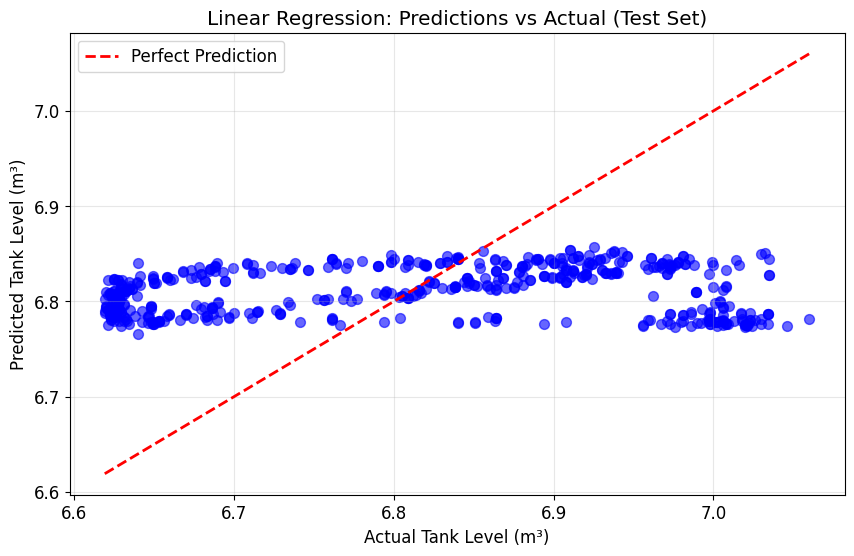

In [6]:
# Linear Regression Model
print("Training Linear Regression Model...")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression model trained successfully!")

# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Calculate metrics
lr_train_mae = mean_absolute_error(y_train, lr_train_pred)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_train_r2 = r2_score(y_train, lr_train_pred)

lr_test_mae = mean_absolute_error(y_test, lr_test_pred)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_test_r2 = r2_score(y_test, lr_test_pred)

print("\nLinear Regression Results:")
print(f"Training MAE: {lr_train_mae:.4f}")
print(f"Training RMSE: {lr_train_rmse:.4f}")
print(f"Training R²: {lr_train_r2:.4f}")
print(f"Test MAE: {lr_test_mae:.4f}")
print(f"Test RMSE: {lr_test_rmse:.4f}")
print(f"Test R²: {lr_test_r2:.4f}")

# Plot predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_test_pred, alpha=0.6, color='blue', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Tank Level (m³)')
plt.ylabel('Predicted Tank Level (m³)')
plt.title('Linear Regression: Predictions vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Model 2: Random Forest

Training Random Forest Model...
Random Forest model trained successfully!

Random Forest Results:
Training MAE: 0.0694
Training RMSE: 0.0885
Training R²: 0.6103
Test MAE: 0.0740
Test RMSE: 0.0920
Test R²: 0.5690


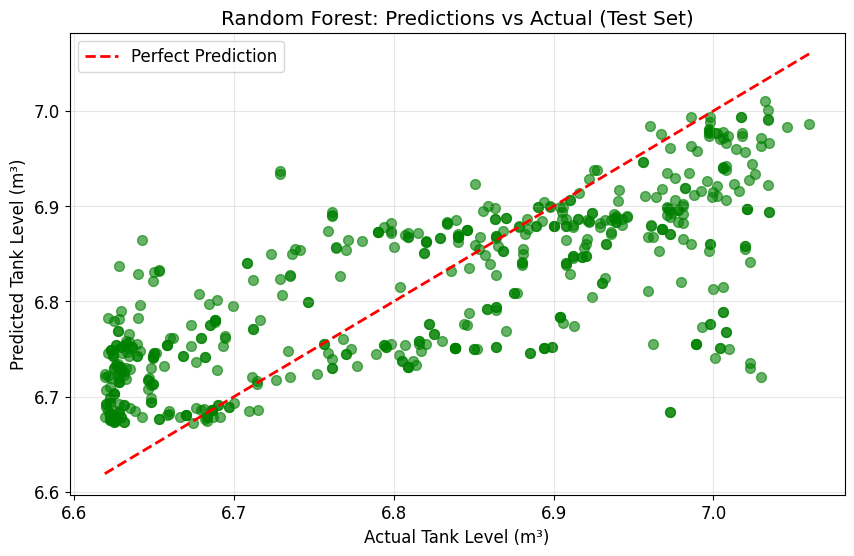


Feature Importances (Random Forest):


,Feature,Importance
3,Tank_Level,0.653946
4,Hour,0.119959
1,Out_Flow_m3h,0.079553
2,Flow_Diff,0.073268
0,Input_Flow_m3h,0.071358
5,Day,0.001916
6,Month,0.000000


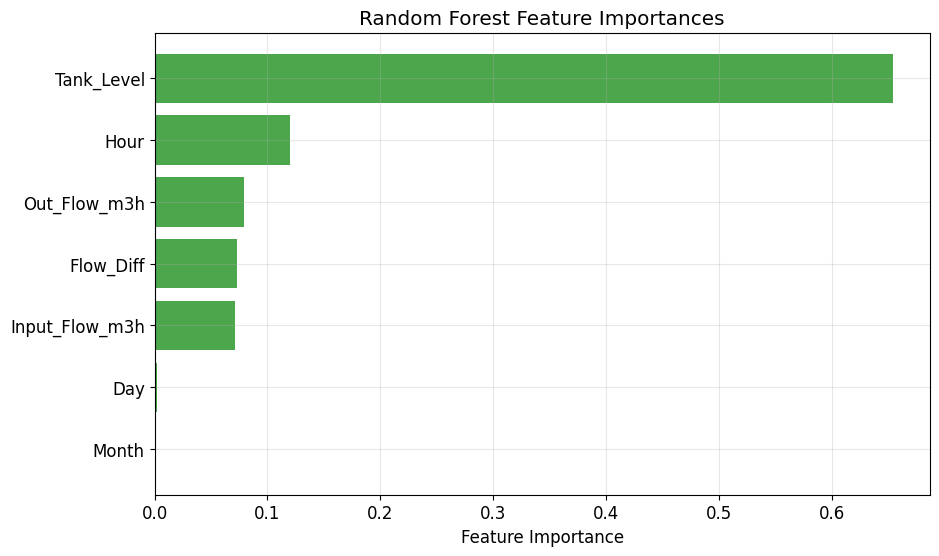

In [7]:
# Random Forest Model
print("Training Random Forest Model...")

# hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=60,  # Moderate number to balance performance and complexity
    max_depth=6,      # Limit tree depth to control overfitting
    min_samples_split=12,  # Increase minimum samples per split
    min_samples_leaf=4,    # Ensure leaves have enough samples
    criterion='squared_error',
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully!")

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Calculate metrics
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_train_r2 = r2_score(y_train, rf_train_pred)

rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_r2 = r2_score(y_test, rf_test_pred)

print("\nRandom Forest Results:")
print(f"Training MAE: {rf_train_mae:.4f}")
print(f"Training RMSE: {rf_train_rmse:.4f}")
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Test MAE: {rf_test_mae:.4f}")
print(f"Test RMSE: {rf_test_rmse:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")

# Plot predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_test_pred, alpha=0.6, color='green', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Tank Level (m³)')
plt.ylabel('Predicted Tank Level (m³)')
plt.title('Random Forest: Predictions vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances (Random Forest):")
display(feature_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='green', alpha=0.7)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Model 3: XGBoost

Training XGBoost Model...
XGBoost model trained successfully!

XGBoost Results:
Training MAE: 0.0022
Training RMSE: 0.0036
Training R²: 0.9994
Test MAE: 0.0069
Test RMSE: 0.0141
Test R²: 0.9898


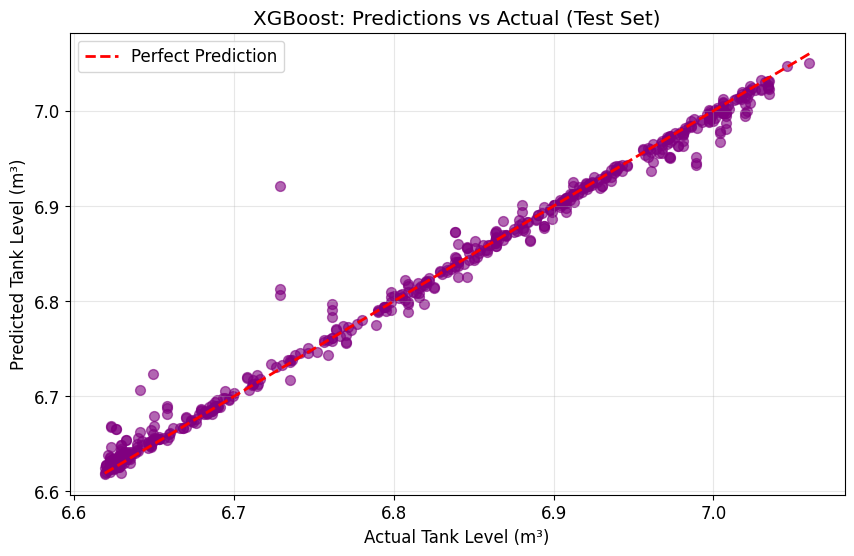


Feature Importances (XGBoost):


,Feature,Importance
3,Tank_Level,0.362121
1,Out_Flow_m3h,0.176258
4,Hour,0.165161
2,Flow_Diff,0.147629
0,Input_Flow_m3h,0.140958
5,Day,0.007873
6,Month,0.000000


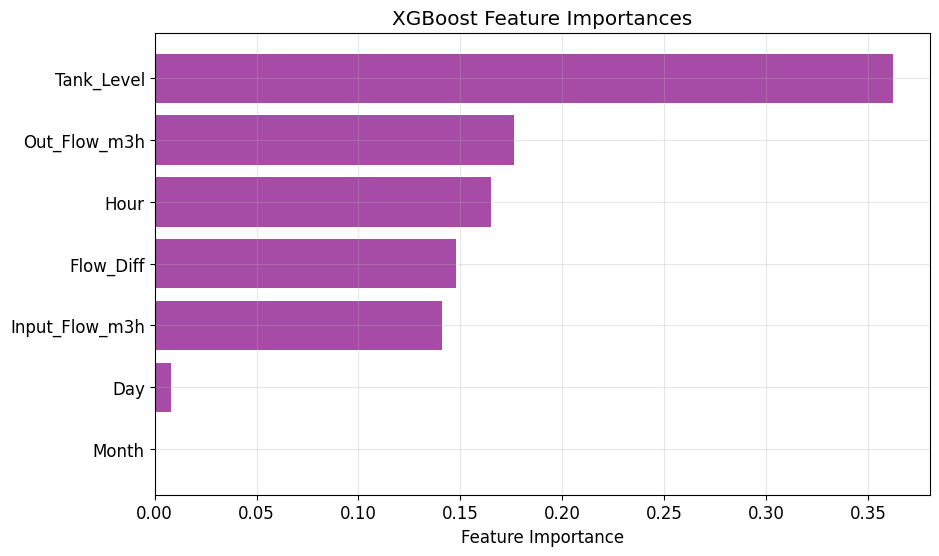

In [8]:
# XGBoost Model
print("Training XGBoost Model...")

# Initialize and train the model with tuned parameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,  # Increased for better fit
    max_depth=8,       # Deeper trees for complex patterns
    learning_rate=0.1, # Moderate learning rate
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
print("XGBoost model trained successfully!")

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate metrics
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
xgb_train_r2 = r2_score(y_train, xgb_train_pred)

xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print("\nXGBoost Results:")
print(f"Training MAE: {xgb_train_mae:.4f}")
print(f"Training RMSE: {xgb_train_rmse:.4f}")
print(f"Training R²: {xgb_train_r2:.4f}")
print(f"Test MAE: {xgb_test_mae:.4f}")
print(f"Test RMSE: {xgb_test_rmse:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")

# Plot predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_test_pred, alpha=0.6, color='purple', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Tank Level (m³)')
plt.ylabel('Predicted Tank Level (m³)')
plt.title('XGBoost: Predictions vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importances
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances (XGBoost):")
display(feature_importance_xgb)

# Plot feature importances
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'], color='purple', alpha=0.7)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Model Performance Comparison

Model Performance Comparison:


,Model,Test MAE,Test RMSE,Test R²
0,Linear Regression,0.119910,0.138021,0.028938
1,Random Forest,0.073969,0.091955,0.568973
2,XGBoost,0.006876,0.014124,0.989831


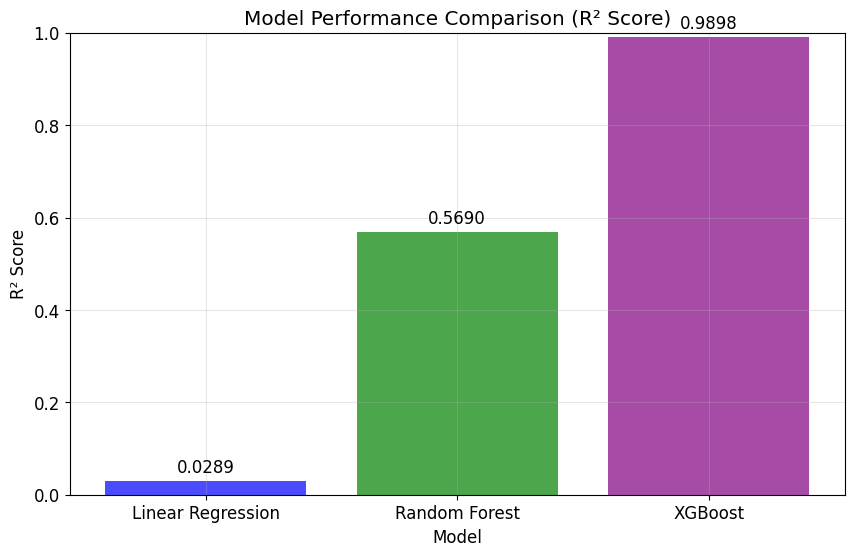

In [9]:
# performance comparison table
performance_data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Test MAE': [lr_test_mae, rf_test_mae, xgb_test_mae],
    'Test RMSE': [lr_test_rmse, rf_test_rmse, xgb_test_rmse],
    'Test R²': [lr_test_r2, rf_test_r2, xgb_test_r2]
}

performance_df = pd.DataFrame(performance_data)
print("Model Performance Comparison:")
display(performance_df)

# Visual comparison of R² scores
models = ['Linear Regression', 'Random Forest', 'XGBoost']
r2_scores = [lr_test_r2, rf_test_r2, xgb_test_r2]
colors = ['blue', 'green', 'purple']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, r2_scores, color=colors, alpha=0.7)
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (R² Score)')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.4f}', ha='center', va='bottom')

plt.show()

## 10. Tank Level Over Time Visualization

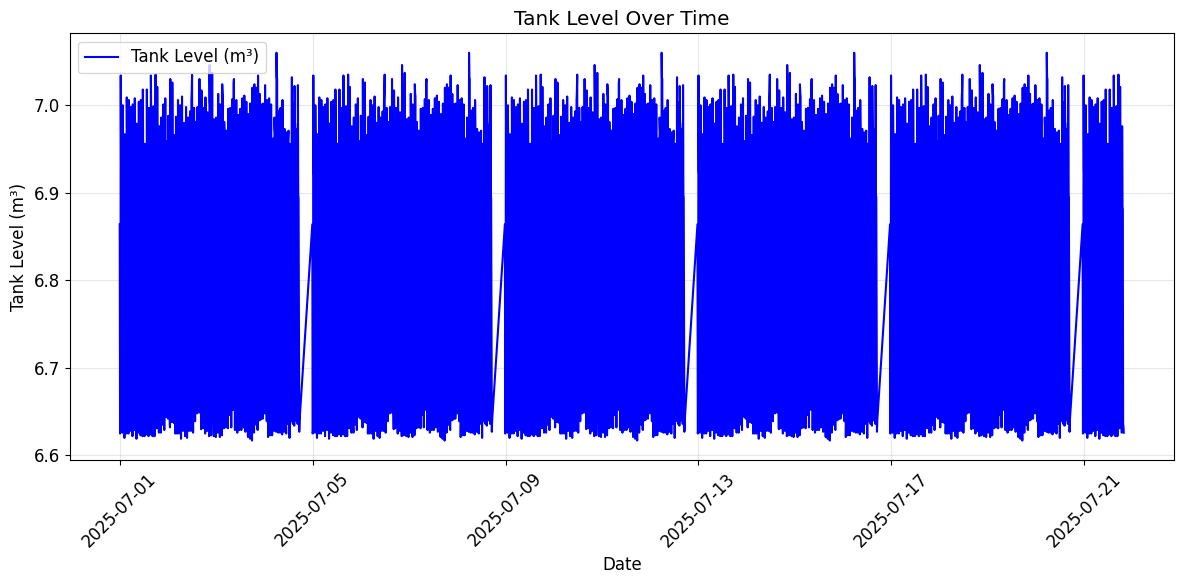

In [10]:
# Plot Tank Level over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Tank_Date'], df['Tank_Level'], label='Tank Level (m³)', color='blue')
plt.xlabel('Date')
plt.ylabel('Tank Level (m³)')
plt.title('Tank Level Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

In [11]:
# Summary statistics
print("=== WATER TANK DEPLETION PREDICTION ANALYSIS ===\n")
print(f"Dataset Overview:")
print(f"- Total samples: {len(df)}")
print(f"- Date range: {df['Tank_Date'].min().strftime('%d/%m/%Y')} to {df['Tank_Date'].max().strftime('%d/%m/%Y')}")
print(f"- Features used: {len(feature_columns)}")
print(f"- Target variable: Next_Tank_Level (m³)")

print(f"\nFeature Engineering:")
print(f"- Input flow standardized to m³/h")
print(f"- Output flow converted to m³/h (L/s × 3.6 if needed)")
print(f"- Flow difference: Input - Output")
print(f"- Time features: Hour, Day, Month")

print(f"\nModel Performance Summary:")
print(f"- Linear Regression R²: {lr_test_r2:.4f}")
print(f"- Random Forest R²: {rf_test_r2:.4f}")
print(f"- XGBoost R²: {xgb_test_r2:.4f}")

# Find best model
best_model = max([(lr_test_r2, 'Linear Regression'), (rf_test_r2, 'Random Forest'), (xgb_test_r2, 'XGBoost')])

print(f"\nBest performing model: {best_model[1]} (R² = {best_model[0]:.4f})")


=== WATER TANK DEPLETION PREDICTION ANALYSIS ===

Dataset Overview:
- Total samples: 2809
- Date range: 01/07/2025 to 21/07/2025
- Features used: 7
- Target variable: Next_Tank_Level (m³)

Feature Engineering:
- Input flow standardized to m³/h
- Output flow converted to m³/h (L/s × 3.6 if needed)
- Flow difference: Input - Output
- Time features: Hour, Day, Month

Model Performance Summary:
- Linear Regression R²: 0.0289
- Random Forest R²: 0.5690
- XGBoost R²: 0.9898

Best performing model: XGBoost (R² = 0.9898)


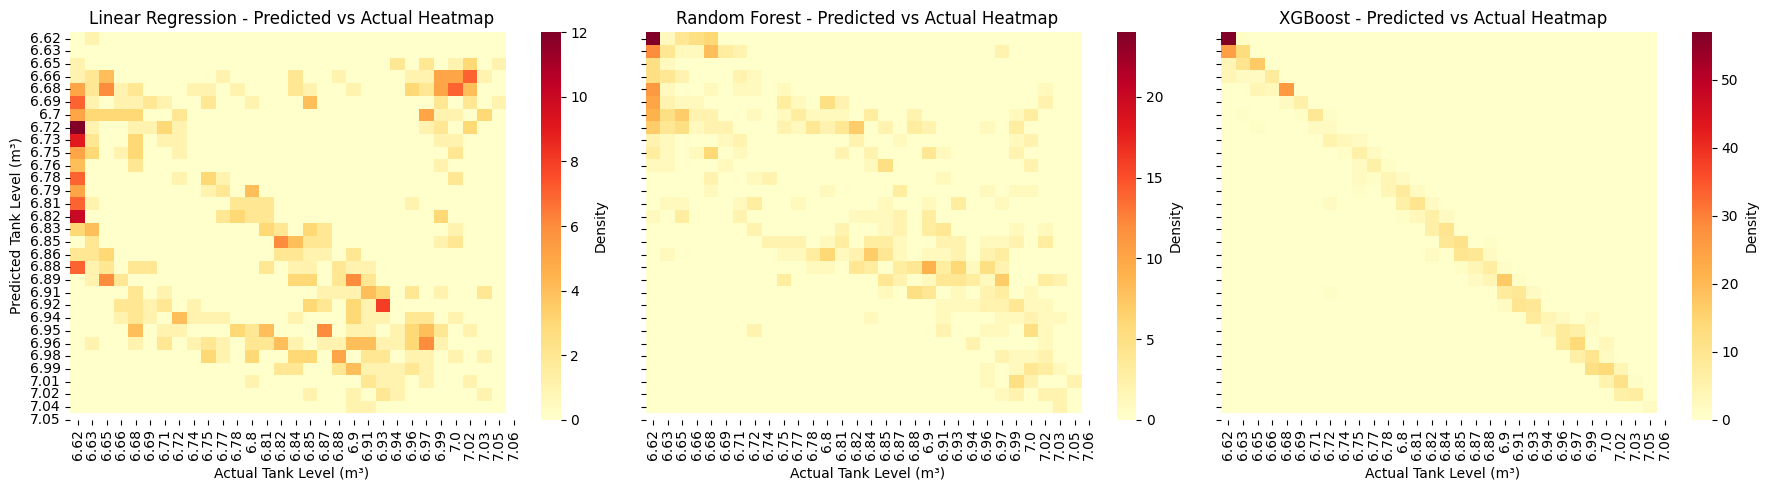

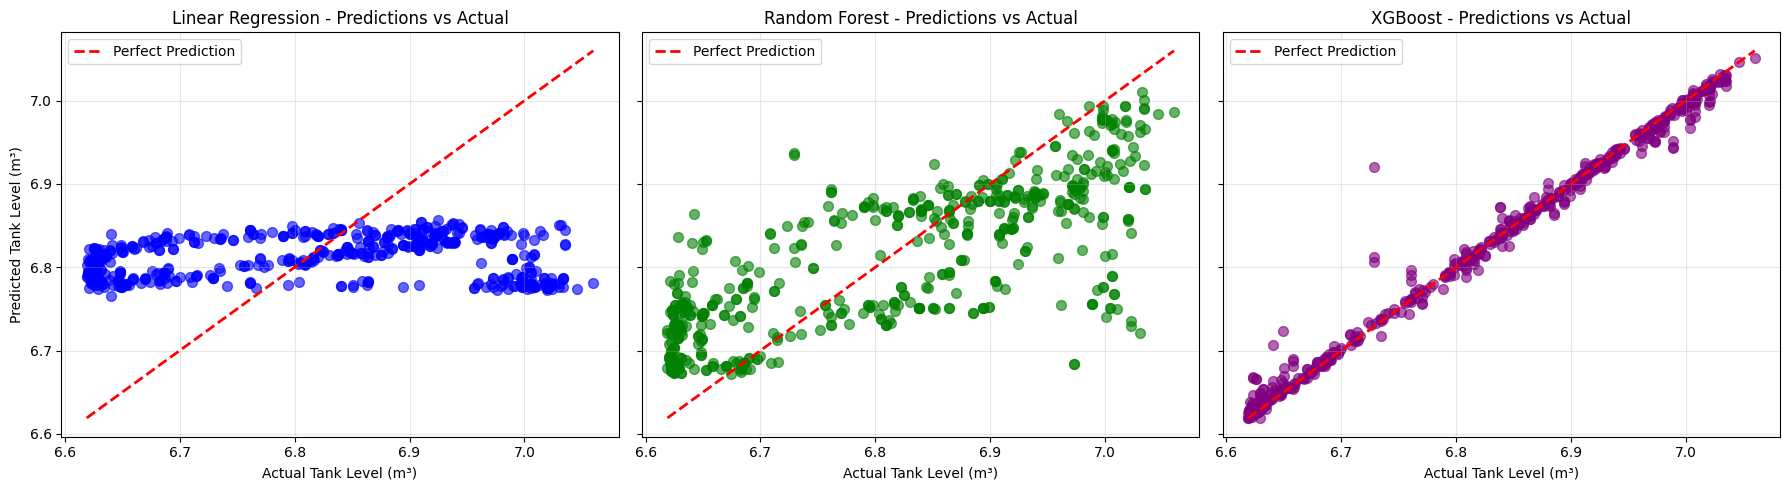

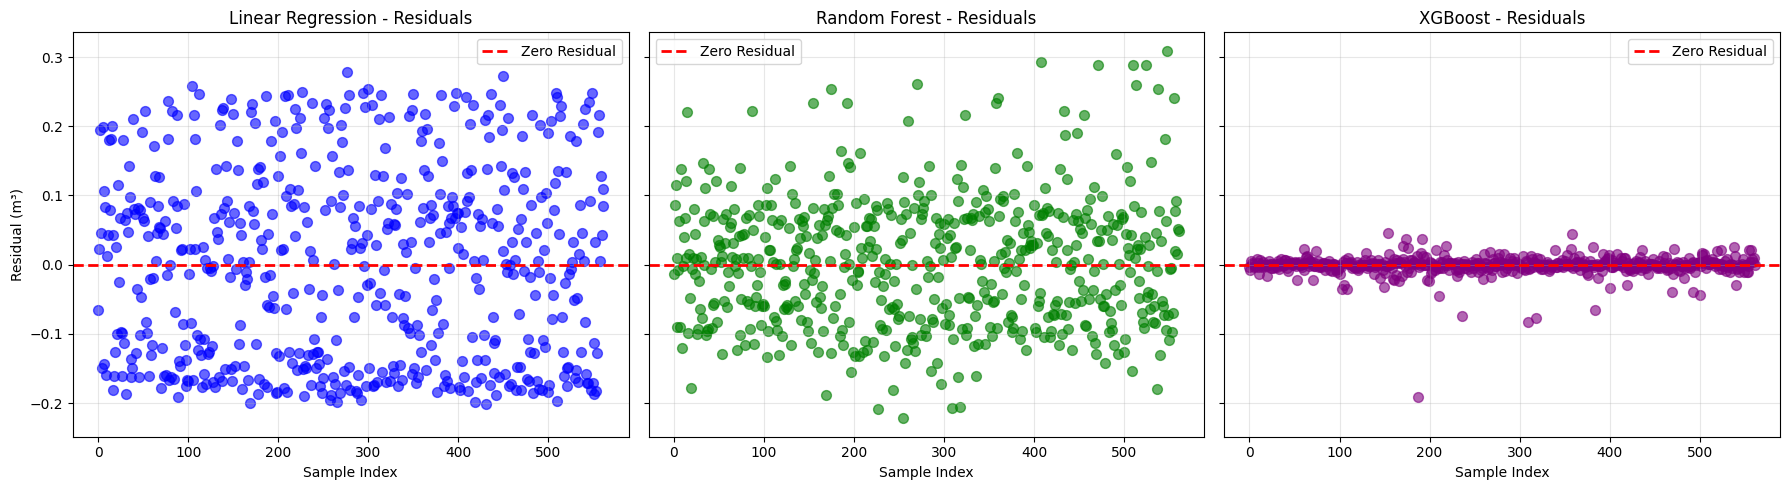

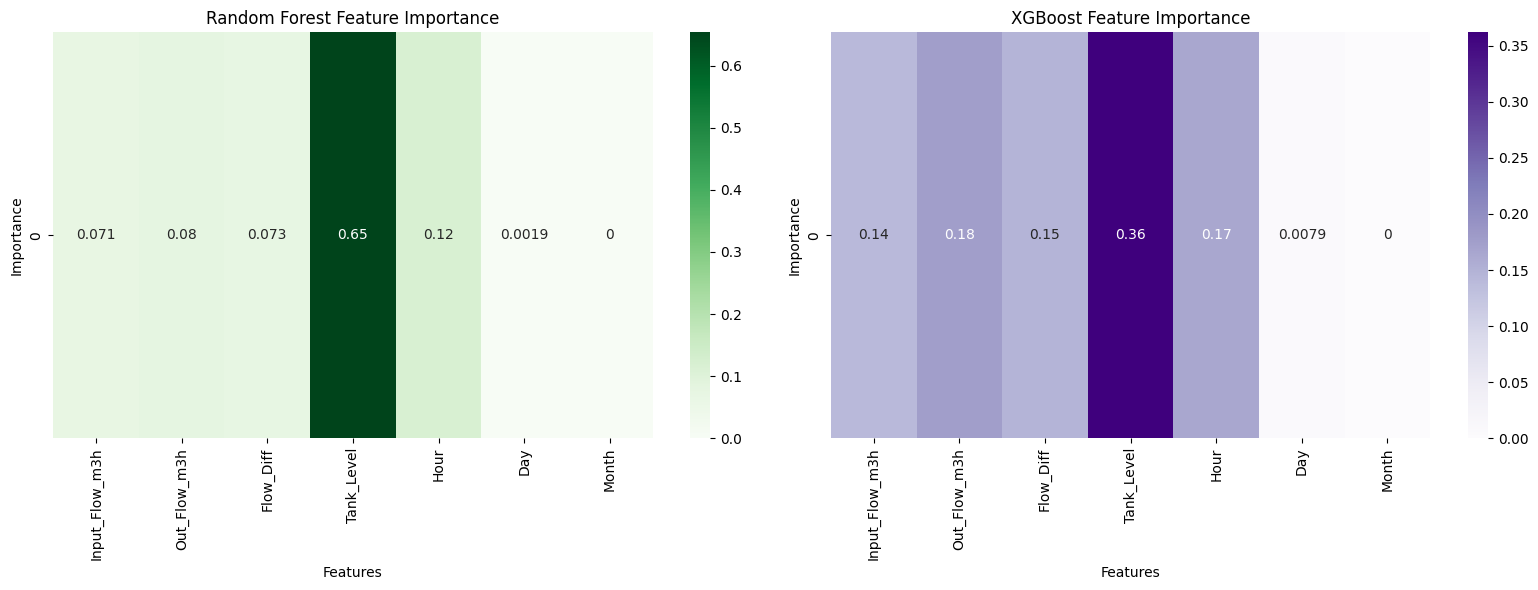

In [12]:
# Comprehensive Model Comparison with Heatmaps and Plots
plt.style.use('default')

# Dictionary of model predictions
predictions = {
    'Linear Regression': lr_test_pred,
    'Random Forest': rf_test_pred,
    'XGBoost': xgb_test_pred
}

# 1. Heatmaps of Predicted vs Actual Values
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, (model_name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    heatmap_data, x_edges, y_edges = np.histogram2d(y_test, pred, bins=30)
    sns.heatmap(heatmap_data.T, ax=ax, cmap='YlOrRd', cbar_kws={'label': 'Density'},
                xticklabels=x_edges.round(2), yticklabels=y_edges.round(2))
    ax.set_title(f'{model_name} - Predicted vs Actual Heatmap')
    ax.set_xlabel('Actual Tank Level (m³)')
    ax.set_ylabel('Predicted Tank Level (m³)' if idx == 0 else '')

plt.tight_layout()
plt.show()

# 2. Scatter Plots of Predicted vs Actual Values
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, (model_name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    ax.scatter(y_test, pred, alpha=0.6, color={'Linear Regression': 'blue', 'Random Forest': 'green', 'XGBoost': 'purple'}[model_name], s=50)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    ax.set_title(f'{model_name} - Predictions vs Actual')
    ax.set_xlabel('Actual Tank Level (m³)')
    ax.set_ylabel('Predicted Tank Level (m³)' if idx == 0 else '')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Residual Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, (model_name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    residuals = y_test - pred
    ax.scatter(range(len(residuals)), residuals, alpha=0.6, color={'Linear Regression': 'blue', 'Random Forest': 'green', 'XGBoost': 'purple'}[model_name], s=50)
    ax.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Residual')
    ax.set_title(f'{model_name} - Residuals')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Residual (m³)' if idx == 0 else '')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Feature Importance Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Random Forest Feature Importance
sns.heatmap([rf_model.feature_importances_], annot=True, cmap='Greens', xticklabels=feature_columns, ax=axes[0])
axes[0].set_title('Random Forest Feature Importance')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')

# XGBoost Feature Importance
sns.heatmap([xgb_model.feature_importances_], annot=True, cmap='Purples', xticklabels=feature_columns, ax=axes[1])
axes[1].set_title('XGBoost Feature Importance')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')

plt.tight_layout()
plt.show()